In [1]:
import torch
import numpy as np
import os, sys
device = 1
os.environ["CUDA_VISIBLE_DEVICES"] = str(device)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from transformers import PreTrainedTokenizer
import json

from data.dataset import CustomTokenizer
from transformers import GPT2Config
from data.circle import make_dataset, compute_canonical_permutation
from model.networks import AttentionOnlyLMHeadModel
from model.eval import decode_batch, generate_samples, compute_perplexity
from model.train import train_main
from model.utils import set_seed
from data.dataset import collate_fn

%load_ext autoreload
%autoreload 2

/scratch/cluster/vansh/miniconda/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEVICE = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# define dataset parameters
dataset_name = "circle"
model_type = "attention-only-12"
model_path = None

M = 15
N = 9
H = 26
HL = 5
seed_per_pi = False
num_train_samples =10000
batch_size = 32
num_eval_samples = 1000
eval_batch_size = 256
num_ckpts = 20
epochs = 20
eval_runs = 1
top_p=1.0
save_name = f"M{M}-N{N}-H{H}-NT{num_train_samples}-E{epochs}-top_p{top_p}-{model_type}"
data_root = f"/datastor1/vansh/lang_sampling/data"
regenerate_data = False

In [3]:
tokenizer = CustomTokenizer()

train_dataset, test_dataset, tokenizer, train_strs, train_perms, VOCAB, SEED_TOKENS, EVAL_TOKENIZER = make_dataset(
                                                                                                                    M=M,
                                                                                                                    N=N,
                                                                                                                    H=H,
                                                                                                                    seed_len=HL,
                                                                                                                    seed_per_pi=seed_per_pi,
                                                                                                                    num_train_samples=num_train_samples,
                                                                                                                    num_test_samples=num_eval_samples,
                                                                                                                    tokenizer=tokenizer,
                                                                                                                    data_root=data_root,
                                                                                                                    regenerate=regenerate_data
                                                                                                                )
VOCAB_IDs = {EVAL_TOKENIZER._convert_token_to_id(tok) for tok in VOCAB}
data_collator = lambda features: collate_fn(features, tokenizer=tokenizer)

BOS token: <BOS>, ID: 0
EOS token: <EOS>, ID: 1
PAD token: <EOS>, ID: 1
Loading existing dataset from /datastor1/vansh/lang_sampling/data/circle/M15-N9
Generated 11000 unique seeds for the strings.
Pre-calculating all training seeds...
Pre-calculating all training seeds...


In [4]:
model_name = model_type.removesuffix("-pretrained")

if model_name == 'attention-only-2':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=128, n_layer=2,
        n_head=4, n_embd=128, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
elif model_name == 'attention-only-4':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=256, n_layer=4,
        n_head=8, n_embd=256, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
elif model_name == 'attention-only-12':
    config = GPT2Config(
        vocab_size=tokenizer.vocab_size, n_positions=1024, n_layer=12,
        n_head=12, n_embd=768, bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
    )
else:
    raise ValueError(f"No configuration defined for model type {model_type}")

# 3. Instantiate the model from scratch or load from a path
if "pretrained" in model_type:
    if not model_path:
        raise ValueError("Must provide 'model_path' in args when using a pretrained model.")
    print(f"Loading pretrained {model_name} model from {model_path}")
    model = AttentionOnlyLMHeadModel.from_pretrained(model_path)
else:
    print(f"Initializing new {model_name} model from scratch")
    model = AttentionOnlyLMHeadModel(config=config)

model.to(DEVICE)
model.resize_token_embeddings(len(tokenizer))
print(f"Model {model_name} initialized with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters.")

Initializing new attention-only-12 model from scratch
Model attention-only-12 initialized with 29182464 trainable parameters.


In [7]:
train_perms_set = set(train_perms)
print(f"Training permutations set size: {len(train_perms_set)}")

def is_coherent_after_walk(seq, N, vocab_ids=VOCAB_IDs) -> bool:
    """
    Given that π exists (walk succeeded), check coherence:
    - correct number of edges
    - correct tokens
    """
    if len(seq) != 2 * N:
        return False

    vocab_set = set(vocab_ids)
    if any(token not in vocab_set for token in seq):
        return False

    return True

def evaluate_model(model, 
                greedy, 
                temperature, 
                label, 
                decode_fn, 
                train_dataset, 
                seed=42, 
                batch_size=eval_batch_size, 
                num_eval_samples=num_eval_samples,
                top_p=top_p):
    set_seed(seed)
    print(f"\nEvaluating {label} for seed {seed}...")

    samples = generate_samples(model, 
                                train_dataset, 
                                tokenizer,
                                decode_fn=decode_fn, 
                                greedy=greedy, 
                                seed_tokens=SEED_TOKENS, 
                                seed_len=HL, 
                                max_length=train_dataset[1]["labels"].shape[0]*2,
                                temperature=temperature, 
                                top_p=top_p, 
                                num_samples=num_eval_samples, 
                                batch_size=batch_size
                                )
    tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]

    unique_perms = set()
    unique_coherent_perms = set()
    num_coherent = 0
    incoherent_samples = []
    # Final metrics loop
    for s in tokenized_samples:
        pi = compute_canonical_permutation(s, N=N)
        if pi is not None:
            unique_perms.add(pi)
            if is_coherent_after_walk(s, N=N, vocab_ids=VOCAB_IDs):
                num_coherent += 1
                unique_coherent_perms.add(pi)
            else:
                incoherent_samples.append(s)
        else:
            incoherent_samples.append(s)

    num_unique_samples = len(set([tuple(s) for s in tokenized_samples])) 

    num_memorized = len([s for s in unique_coherent_perms if s in train_perms_set])
    num_creative = len([s for s in unique_coherent_perms if s not in train_perms_set])
    num_unique_perms = len(unique_perms)

    representation_power = (num_memorized / len(samples))
    creativity = (num_creative / len(samples)) 
    uniqueness = (num_unique_perms / len(samples)) 
    coherence = (num_coherent / len(samples)) 

    uniqueness_strings = (num_unique_samples / len(samples)) 
    # perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

    # print(f"Perplexity: {perplexity:.4f}")
    print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
    print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
    print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
    print(f"Uniqueness (permutations): {uniqueness:.4f} ({num_unique_perms}/{len(samples)})")
    print(f"Uniqueness (strings): {uniqueness_strings:.4f} ({num_unique_samples}/{len(samples)})")

    return np.array([
        representation_power,
        creativity,
        uniqueness,
        coherence,
        len(samples)
    ])

Training permutations set size: 8870



--- Running Learning Rate Finder ---


 93%|█████████▎| 93/100 [00:03<00:00, 28.42it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.58E-04


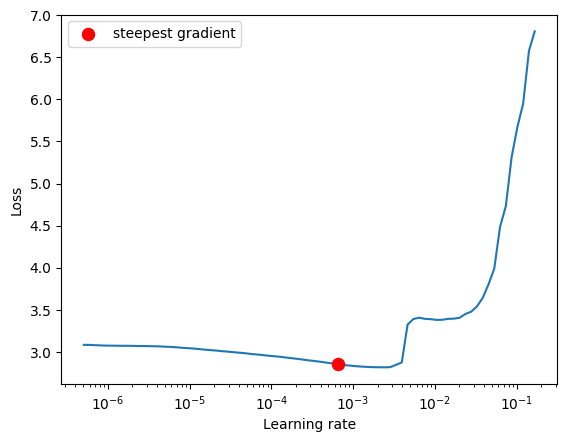

LR Finder plot saved to lr_finder.png

--- LR Finder complete. You can now use the suggested LR for training. ---


In [ ]:
# from torch_lr_finder import LRFinder, TrainDataLoaderIter
# import torch.optim as optim
# import torch.nn as nn

# class HFTrainLoaderIter(TrainDataLoaderIter):
#     def inputs_labels_from_batch(self, batch_data):
#         return batch_data, batch_data["labels"]

# class ModelWrapper(nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.model = model

#     def forward(self, inputs):
#         return self.model(**inputs)

# def hf_criterion(outputs, labels):
#     return outputs.loss


# train_loader = torch.utils.data.DataLoader(
#     train_dataset,
#     batch_size=batch_size, # Use the same batch size as your main training
#     collate_fn=data_collator,
#     shuffle=True
# )


# # --- LR Finder ---
# print("\n--- Running Learning Rate Finder ---")

# # 1. Wrap the model
# wrapped_model = ModelWrapper(model)

# # 2. Define optimizer
# optimizer = optim.Adam(wrapped_model.parameters(), lr=1e-7, weight_decay=0.01)

# # 3. Wrap the DataLoader
# hf_train_iter = HFTrainLoaderIter(train_loader)

# # 4. Initialize and run the finder
# lr_finder = LRFinder(wrapped_model, optimizer, hf_criterion, device=DEVICE)
# lr_finder.range_test(hf_train_iter, end_lr=1, num_iter=100)

# # 5. Plot and reset
# lr_finder.plot() # Saves lr_finder.png
# print("LR Finder plot saved to lr_finder.png")
# lr_finder.reset()

# print("\n--- LR Finder complete. You can now use the suggested LR for training. ---")



In [8]:
train_main(
    model=model,
    dataset_name=dataset_name,
    save_name=save_name,
    hl=HL,
    batch_size=batch_size,
    num_epochs=epochs,
    temperatures=[0.3, 0.5, 0.7, 1.0, 2.0],
    num_eval_runs=eval_runs,
    train_dataset=train_dataset,
    data_collator=data_collator,
    device=DEVICE,
    decode_fn=decode_batch,
    eval_fn=evaluate_model,
    num_checkpoints=num_ckpts,
    log_to_wandb=False,
    save_results=True, 
    lr=1e-4
)

{'loss': 2.7466, 'grad_norm': 1.7839540243148804, 'learning_rate': 9.96964856230032e-05, 'epoch': 0.06389776357827476}
{'loss': 2.6081, 'grad_norm': 1.7746158838272095, 'learning_rate': 9.937699680511182e-05, 'epoch': 0.12779552715654952}
{'loss': 2.596, 'grad_norm': 1.2530577182769775, 'learning_rate': 9.905750798722045e-05, 'epoch': 0.19169329073482427}
{'loss': 2.5844, 'grad_norm': 1.4992753267288208, 'learning_rate': 9.873801916932908e-05, 'epoch': 0.25559105431309903}
{'loss': 2.5772, 'grad_norm': 1.730760097503662, 'learning_rate': 9.841853035143771e-05, 'epoch': 0.3194888178913738}
{'loss': 2.57, 'grad_norm': 1.6649562120437622, 'learning_rate': 9.809904153354633e-05, 'epoch': 0.38338658146964855}
{'loss': 2.5585, 'grad_norm': 1.808052897453308, 'learning_rate': 9.777955271565496e-05, 'epoch': 0.4472843450479233}
{'loss': 2.5368, 'grad_norm': 1.4642049074172974, 'learning_rate': 9.746006389776359e-05, 'epoch': 0.5111821086261981}
{'loss': 2.4654, 'grad_norm': 1.3726166486740112,

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 313

Evaluating Step 313 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 313 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 313 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0010 (1/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0010 (1/1000)
Uniqueness (permutations): 0.0010 (1/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 313 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0370 (37/1000)
Representation power: 0.0060 (6/1000)
Creativity: 0.0310 (31/1000)
Uniqueness (permutations): 0.0370 (37/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evalua

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 626

Evaluating Step 626 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 626 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 626 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0090 (9/1000)
Representation power: 0.0010 (1/1000)
Creativity: 0.0080 (8/1000)
Uniqueness (permutations): 0.0090 (9/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 626 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0560 (56/1000)
Representation power: 0.0130 (13/1000)
Creativity: 0.0430 (43/1000)
Uniqueness (permutations): 0.0560 (56/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evalu

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 939

Evaluating Step 939 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 939 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0060 (6/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0060 (6/1000)
Uniqueness (permutations): 0.0060 (6/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 939 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0420 (42/1000)
Representation power: 0.0080 (8/1000)
Creativity: 0.0330 (33/1000)
Uniqueness (permutations): 0.0410 (41/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 939 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1190 (119/1000)
Representation power: 0.0240 (24/1000)
Creativity: 0.0950 (95/1000)
Uniqueness (permutations): 0.1190 (119/1000)
Uniqueness (strings): 1.0000 (1000/1000)



The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 1252

Evaluating Step 1252 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 1252 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0380 (38/1000)
Representation power: 0.0060 (6/1000)
Creativity: 0.0260 (26/1000)
Uniqueness (permutations): 0.0320 (32/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1252 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0860 (86/1000)
Representation power: 0.0150 (15/1000)
Creativity: 0.0700 (70/1000)
Uniqueness (permutations): 0.0850 (85/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1252 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1520 (152/1000)
Representation power: 0.0380 (38/1000)
Creativity: 0.1140 (114/1000)
Uniqueness (permutations): 0.1520 (152/1000)
Uniqueness (strings): 1.0000 (1000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 1565

Evaluating Step 1565 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 1565 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0530 (53/1000)
Representation power: 0.0080 (8/1000)
Creativity: 0.0370 (37/1000)
Uniqueness (permutations): 0.0450 (45/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1565 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1020 (102/1000)
Representation power: 0.0310 (31/1000)
Creativity: 0.0680 (68/1000)
Uniqueness (permutations): 0.0990 (99/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1565 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1610 (161/1000)
Representation power: 0.0300 (30/1000)
Creativity: 0.1300 (130/1000)
Uniqueness (permutations): 0.1600 (160/1000)
Uniqueness (strings): 1.0000 (100

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 1878

Evaluating Step 1878 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 1878 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0640 (64/1000)
Representation power: 0.0150 (15/1000)
Creativity: 0.0390 (39/1000)
Uniqueness (permutations): 0.0540 (54/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1878 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0940 (94/1000)
Representation power: 0.0190 (19/1000)
Creativity: 0.0700 (70/1000)
Uniqueness (permutations): 0.0890 (89/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 1878 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1670 (167/1000)
Representation power: 0.0420 (42/1000)
Creativity: 0.1230 (123/1000)
Uniqueness (permutations): 0.1650 (165/1000)
Uniqueness (strings): 1.0000 (100

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 2191

Evaluating Step 2191 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 2191 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.0930 (93/1000)
Representation power: 0.0130 (13/1000)
Creativity: 0.0680 (68/1000)
Uniqueness (permutations): 0.0810 (81/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2191 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1450 (145/1000)
Representation power: 0.0280 (28/1000)
Creativity: 0.1140 (114/1000)
Uniqueness (permutations): 0.1420 (142/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2191 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1840 (184/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1420 (142/1000)
Uniqueness (permutations): 0.1820 (182/1000)
Uniqueness (strings): 1.0000 (

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'loss': 1.5891, 'grad_norm': 1.505344033241272, 'learning_rate': 6.007987220447284e-05, 'epoch': 7.987220447284345}

📈 Live evaluation at step 2504

Evaluating Step 2504 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 2504 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1460 (146/1000)
Representation power: 0.0270 (27/1000)
Creativity: 0.1090 (109/1000)
Uniqueness (permutations): 0.1360 (136/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2504 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1710 (171/1000)
Representation power: 0.0380 (38/1000)
Creativity: 0.1280 (128/1000)
Uniqueness (permutations): 0.1660 (166/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2504 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2260 (226/1000)
Representation power: 0.0380 (38/1000)
Creativity: 0.1860 (186/1000)
Uniqueness (permutations): 0.2240 (224/1000)
Uniqueness (strings): 1.000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 2817

Evaluating Step 2817 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 2817 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1480 (148/1000)
Representation power: 0.0360 (36/1000)
Creativity: 0.1060 (106/1000)
Uniqueness (permutations): 0.1420 (142/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2817 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1770 (177/1000)
Representation power: 0.0310 (31/1000)
Creativity: 0.1460 (146/1000)
Uniqueness (permutations): 0.1770 (177/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 2817 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2040 (204/1000)
Representation power: 0.0510 (51/1000)
Creativity: 0.1500 (150/1000)
Uniqueness (permutations): 0.2010 (201/1000)
Uniqueness (strings): 1.000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 3130

Evaluating Step 3130 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 3130 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1610 (161/1000)
Representation power: 0.0410 (41/1000)
Creativity: 0.1160 (116/1000)
Uniqueness (permutations): 0.1570 (157/1000)
Uniqueness (strings): 0.9980 (998/1000)

Evaluating Step 3130 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1830 (183/1000)
Representation power: 0.0370 (37/1000)
Creativity: 0.1430 (143/1000)
Uniqueness (permutations): 0.1800 (180/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3130 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2160 (216/1000)
Representation power: 0.0530 (53/1000)
Creativity: 0.1610 (161/1000)
Uniqueness (permutations): 0.2140 (214/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'loss': 1.4281, 'grad_norm': 1.6730287075042725, 'learning_rate': 4.506389776357828e-05, 'epoch': 10.99041533546326}

📈 Live evaluation at step 3443

Evaluating Step 3443 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 3443 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1340 (134/1000)
Representation power: 0.0280 (28/1000)
Creativity: 0.1010 (101/1000)
Uniqueness (permutations): 0.1290 (129/1000)
Uniqueness (strings): 0.9980 (998/1000)

Evaluating Step 3443 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1650 (165/1000)
Representation power: 0.0330 (33/1000)
Creativity: 0.1280 (128/1000)
Uniqueness (permutations): 0.1610 (161/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3443 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1900 (190/1000)
Representation power: 0.0360 (36/1000)
Creativity: 0.1510 (151/1000)
Uniqueness (permutations): 0.1870 (187/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 3756

Evaluating Step 3756 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 3756 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1610 (161/1000)
Representation power: 0.0350 (35/1000)
Creativity: 0.1240 (124/1000)
Uniqueness (permutations): 0.1590 (159/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 3756 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1560 (156/1000)
Representation power: 0.0300 (30/1000)
Creativity: 0.1240 (124/1000)
Uniqueness (permutations): 0.1540 (154/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 3756 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1810 (181/1000)
Representation power: 0.0410 (41/1000)
Creativity: 0.1380 (138/1000)
Uniqueness (permutations): 0.1790 (179/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 4069

Evaluating Step 4069 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 4069 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1690 (169/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1260 (126/1000)
Uniqueness (permutations): 0.1660 (166/1000)
Uniqueness (strings): 0.9940 (994/1000)

Evaluating Step 4069 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1640 (164/1000)
Representation power: 0.0330 (33/1000)
Creativity: 0.1290 (129/1000)
Uniqueness (permutations): 0.1620 (162/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 4069 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1940 (194/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1530 (153/1000)
Uniqueness (permutations): 0.1930 (193/1000)
Uniqueness (strings): 1.0000 

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'loss': 1.2743, 'grad_norm': 1.892744541168213, 'learning_rate': 3.0047923322683707e-05, 'epoch': 13.993610223642172}

📈 Live evaluation at step 4382

Evaluating Step 4382 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 4382 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1550 (155/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1100 (110/1000)
Uniqueness (permutations): 0.1500 (150/1000)
Uniqueness (strings): 0.9910 (991/1000)

Evaluating Step 4382 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1850 (185/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1430 (143/1000)
Uniqueness (permutations): 0.1830 (183/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 4382 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1960 (196/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1550 (155/1000)
Uniqueness (permutations): 0.1950 (195/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 4695

Evaluating Step 4695 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 1.0000 (1000/1000)
Representation power: 0.0010 (1/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0010 (1/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 4695 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1930 (193/1000)
Representation power: 0.0510 (51/1000)
Creativity: 0.1330 (133/1000)
Uniqueness (permutations): 0.1840 (184/1000)
Uniqueness (strings): 0.9870 (987/1000)

Evaluating Step 4695 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2020 (202/1000)
Representation power: 0.0440 (44/1000)
Creativity: 0.1570 (157/1000)
Uniqueness (permutations): 0.2010 (201/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 4695 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2200 (220/1000)
Representation power: 0.0450 (45/1000)
Creativity: 0.1740 (174/1000)
Uniqueness (permutations): 0.2190 (219/1000)
Uniqueness (strings): 1.0

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 5008

Evaluating Step 5008 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 5008 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2010 (201/1000)
Representation power: 0.0640 (64/1000)
Creativity: 0.1330 (133/1000)
Uniqueness (permutations): 0.1970 (197/1000)
Uniqueness (strings): 0.9900 (990/1000)

Evaluating Step 5008 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1870 (187/1000)
Representation power: 0.0400 (40/1000)
Creativity: 0.1470 (147/1000)
Uniqueness (permutations): 0.1870 (187/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 5008 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1960 (196/1000)
Representation power: 0.0430 (43/1000)
Creativity: 0.1520 (152/1000)
Uniqueness (permutations): 0.1950 (195/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


{'loss': 1.1823, 'grad_norm': 1.8959641456604004, 'learning_rate': 1.5031948881789137e-05, 'epoch': 16.996805111821086}

📈 Live evaluation at step 5321

Evaluating Step 5321 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 5321 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2150 (215/1000)
Representation power: 0.0550 (55/1000)
Creativity: 0.1480 (148/1000)
Uniqueness (permutations): 0.2030 (203/1000)
Uniqueness (strings): 0.9880 (988/1000)

Evaluating Step 5321 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2190 (219/1000)
Representation power: 0.0530 (53/1000)
Creativity: 0.1630 (163/1000)
Uniqueness (permutations): 0.2160 (216/1000)
Uniqueness (strings): 1.0000 (1000/1000)

Evaluating Step 5321 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2080 (208/1000)
Representation power: 0.0410 (41/1000)
Creativity: 0.1650 (165/1000)
Uniqueness (permutations): 0.2060 (206/1000)
Uniqueness (strings): 1.0000

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 5634

Evaluating Step 5634 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 1.0000 (1000/1000)
Representation power: 0.0010 (1/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0010 (1/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 5634 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2150 (215/1000)
Representation power: 0.0680 (68/1000)
Creativity: 0.1350 (135/1000)
Uniqueness (permutations): 0.2030 (203/1000)
Uniqueness (strings): 0.9860 (986/1000)

Evaluating Step 5634 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2030 (203/1000)
Representation power: 0.0520 (52/1000)
Creativity: 0.1490 (149/1000)
Uniqueness (permutations): 0.2010 (201/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 5634 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2000 (200/1000)
Representation power: 0.0440 (44/1000)
Creativity: 0.1540 (154/1000)
Uniqueness (permutations): 0.1980 (198/1000)
Uniqueness (strings): 1.00

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 5947

Evaluating Step 5947 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 5947 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2120 (212/1000)
Representation power: 0.0590 (59/1000)
Creativity: 0.1370 (137/1000)
Uniqueness (permutations): 0.1960 (196/1000)
Uniqueness (strings): 0.9880 (988/1000)

Evaluating Step 5947 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.1830 (183/1000)
Representation power: 0.0490 (49/1000)
Creativity: 0.1310 (131/1000)
Uniqueness (permutations): 0.1800 (180/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 5947 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2110 (211/1000)
Representation power: 0.0410 (41/1000)
Creativity: 0.1680 (168/1000)
Uniqueness (permutations): 0.2090 (209/1000)
Uniqueness (strings): 1.0000 

The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



📈 Live evaluation at step 6260

Evaluating Step 6260 argmax for seed 42...

Generating 1000 unconditional samples.


The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Coherence: 0.0000 (0/1000)
Representation power: 0.0000 (0/1000)
Creativity: 0.0000 (0/1000)
Uniqueness (permutations): 0.0000 (0/1000)
Uniqueness (strings): 0.0010 (1/1000)

Evaluating Step 6260 softmax @ temp=0.3 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2170 (217/1000)
Representation power: 0.0630 (63/1000)
Creativity: 0.1410 (141/1000)
Uniqueness (permutations): 0.2040 (204/1000)
Uniqueness (strings): 0.9890 (989/1000)

Evaluating Step 6260 softmax @ temp=0.5 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2100 (210/1000)
Representation power: 0.0570 (57/1000)
Creativity: 0.1490 (149/1000)
Uniqueness (permutations): 0.2060 (206/1000)
Uniqueness (strings): 0.9990 (999/1000)

Evaluating Step 6260 softmax @ temp=0.7 for seed 42...

Generating 1000 unconditional samples.
Coherence: 0.2070 (207/1000)
Representation power: 0.0390 (39/1000)
Creativity: 0.1650 (165/1000)
Uniqueness (permutations): 0.2040 (204/1000)
Uniqueness (strings): 1.0000 

In [9]:
samples = generate_samples(model, 
                                train_dataset, 
                                tokenizer,
                                decode_fn=decode_batch, 
                                greedy=False, 
                                seed_tokens=SEED_TOKENS, 
                                seed_len=HL, 
                                max_length=train_dataset[1]["labels"].shape[0]*2,
                                temperature=1.0, 
                                top_p=top_p, 
                                num_samples=num_eval_samples, 
                                batch_size=batch_size
                                )

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Generating 1000 unconditional samples.


In [10]:
tokenized_samples = [EVAL_TOKENIZER.encode(s) for s in samples]

unique_perms = set()
unique_coherent_perms = set()
num_coherent = 0
incoherent_samples = []
# Final metrics loop
for s in tokenized_samples:
    pi = compute_canonical_permutation(s, N=N)
    if pi is not None:
        unique_perms.add(pi)
        if is_coherent_after_walk(s, N=N, vocab_ids=VOCAB_IDs):
            num_coherent += 1
            unique_coherent_perms.add(pi)
        else:
            incoherent_samples.append(s)
    else:
        incoherent_samples.append(s)


num_memorized = len([s for s in unique_coherent_perms if s in train_perms_set])
num_creative = len([s for s in unique_coherent_perms if s not in train_perms_set])
num_unique = len(unique_perms)

representation_power = (num_memorized / len(samples))
creativity = (num_creative / len(samples)) 
uniqueness = (num_unique / len(samples)) 
coherence = (num_coherent / len(samples)) 
# perplexity = compute_perplexity(model, test_dataset, batch_size=batch_size)

# print(f"Perplexity: {perplexity:.4f}")
print(f"Coherence: {coherence:.4f} ({num_coherent}/{len(samples)})")
print(f"Representation power: {representation_power:.4f} ({num_memorized}/{len(samples)})")
print(f"Creativity: {creativity:.4f} ({num_creative}/{len(samples)})")
print(f"Uniqueness: {uniqueness:.4f} ({num_unique}/{len(samples)})")

Coherence: 0.9340 (934/1000)
Representation power: 0.0020 (2/1000)
Creativity: 0.0000 (0/1000)
Uniqueness: 0.0020 (2/1000)


In [11]:
samples[:10]

['v17 v5 v0 v17 v5 v0',
 'v12 v18 v18 v8 v8 v12',
 'v9 v12 v12 v8 v8 v9',
 'v10 v20 v26 v10 v20 v26',
 'v18 v15 v15 v12 v12 v18',
 'v9 v14 v14 v24 v24 v9',
 'v19 v29 v24 v19 v29 v24',
 'v19 v12 v12 v19 v12 v19',
 'v15 v2 v2 v0 v0 v15',
 'v5 v27 v27 v5 v27 v5']